In this notebook we check which census knots share the same 0-surgery with a low crossing knot (of at most 15 crossings).

We first create a list of all Alexander polynomials of census knots and check which low crossing knots have equal Alexander polynomials.

In [1]:
import snappy
import time
import csv
import itertools
import pickle

def all_positive(manifold):
    '''
    Checks if the solution type of a triangulation is positive.
    '''
    return manifold.solution_type() == 'all tetrahedra positively oriented'

def find_positive_triangulations(manifold,number=1,tries=100):
    '''
    Searches for one triangulation with a positive solution type.
    (Or if number is set to a different value also for different such triangulations.)
    '''
    M = manifold.copy()
    pos_triangulations=[]
    for i in range(tries):
        if all_positive(M):
            pos_triangulations.append(M)
            if len(pos_triangulations)==number:
                return pos_triangulations
            break
        M.randomize()
    for d in M.dual_curves(max_segments=500):
        X = M.drill(d)
        X = X.filled_triangulation()
        X.dehn_fill((1,0),-1)
        for i in range(tries):
            if all_positive(X):
                pos_triangulations.append(X)
                if len(pos_triangulations)==number:
                    return pos_triangulations
                break
            X.randomize()

    # In the closed case, here is another trick.
    if all(not c for c in M.cusp_info('is_complete')):
        for i in range(tries):
            # Drills out a random edge
            X = M.__class__(M.filled_triangulation())
            if all_positive(X):
                pos_triangulations.append(X)
                if len(pos_triangulations)==number:
                    return pos_triangulations
            break
            M.randomize()
    return pos_triangulations

def better_volume(M,index=100,try_hard=False):
    '''Computes the verified volume. Returns 0 if SnapPy could not do it.'''
    count=0
    while count<index:
        try:
            return M.volume(verified=True)
        except:
            M.randomize()
            count=count+1
    if try_hard==True:
        pos_triang=find_positive_triangulations(M,number=index,tries=index)
        for X in pos_triang:
            vol=better_volume(X,index)
            if vol!=0:
                return vol
    return 0

def subgroups_of_order_n(M,n):
    '''
    Returns the number of subgroups of order n of the fundamental group of M.
    Warning: Works only fast for small n.
    '''
    return len(snappy.Manifold(M).covers(n))

def subgroups_up_to_order_k(M,k):
    '''
    Returns the vector containing the number of subgroups of order n of the fundamental group of M for n=2,...,k.
    Warning: Works only fast for small k.
    '''
    vector=[]
    for n in range(2,k+1):
        vector.append(subgroups_of_order_n(M,n))
    return vector

def better_is_isometric_to(X,Y,return_isometries=False,index=100,try_hard=False):
    """
    Returns True if X and Y are isometric.
    Returns False if X and Y have different homologies.
     """ 
    if return_isometries==False:
        w='unclear'
        if X.homology()!=Y.homology():
            return False
        for i in (0,index):
            try:
                w=X.is_isometric_to(Y)
            except (RuntimeError,snappy.SnapPeaFatalError):
                pass
            if w==True:
                return w
            X.randomize()
            Y.randomize()
            i=i+1
        if try_hard:
            pos_triang_X=find_positive_triangulations(X,number=10,tries=index)
            pos_triang_Y=find_positive_triangulations(Y,number=10,tries=index)
            for X in pos_triang_X:
                for Y in pos_triang_Y:
                    w=better_is_isometric_to(X,Y,index=100,try_hard=False)
                    if w==True:
                        return w
        return 'unclear'
    if return_isometries==True:
        w=False
        if X.homology()!=Y.homology():
            return []
        for i in (0,index):
            try:
                w=X.is_isometric_to(Y,return_isometries)
            except (RuntimeError,snappy.SnapPeaFatalError):
                pass
            if w!=False:
                return w
            X.randomize()
            Y.randomize()
            i=i+1
        if try_hard:
            pos_triang_X=find_positive_triangulations(X,number=10,tries=index)
            pos_triang_Y=find_positive_triangulations(Y,number=10,tries=index)
            for X in pos_triang_X:
                for Y in pos_triang_Y:
                    w=better_is_isometric_to(X,Y,return_isometries,index=100,try_hard=False)
                    if w!=False:
                        return w
        return []

In [2]:
start_time = time.time()
ALEX_GROUP=[]
alexander_polynomials=[]

for K in snappy.CensusKnots():
    f=K.alexander_polynomial()
    if f not in alexander_polynomials:
        alexander_polynomials.append(f)
        ALEX_GROUP.append([f,[K.identify()[0].name()]])
    else:
        for [pol,knots] in ALEX_GROUP:
            if pol==f:
                knots.append(K.identify()[0].name())

print('Number of different Alexander polynomials:',len(alexander_polynomials))
print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

Number of different Alexander polynomials: 1135
Time taken: 1.0360559622446697 minutes 


In [3]:
start_time = time.time()

for K in snappy.HTLinkExteriors(knots_vs_links='knots'):
    if K not in snappy.CensusKnots():
        f=K.alexander_polynomial()
        if f in alexander_polynomials:
            for [pol,knots] in ALEX_GROUP:
                if pol==f:
                    knots.append(K.name())

print('Number of different Alexander polynomials:',len(alexander_polynomials))
print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

Number of different Alexander polynomials: 1135
Time taken: 76.12658732732137 minutes 


In [5]:
ALEX_GROUPS_WITH_MORE_THAN_ONE_KNOT=[x for x in ALEX_GROUP if len(x[1])>1]

In [6]:
len(ALEX_GROUPS_WITH_MORE_THAN_ONE_KNOT)

200

For each knot in the list, we check if the 0-filling is hyperbolic. If yes we compare their verified volumes, if not we compare their regina names.

First, we load these data.

In [17]:
exceptional_fillings=[]
with open('exceptional_fillings.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        exceptional_fillings.append(row)
len(exceptional_fillings)

205823

In [21]:
volumes_low_cros=pickle.load( open( "volumes.pickle", "rb" ) )
len(volumes_low_cros)

313138

In [13]:
NOT_HYP=[['K3a1', 'SFS [S2: (2,1) (3,1) (6,-5)]'],
 ['K4a1', 'T x I / [ 2,1 | 1,1 ]'],
 ['K5a1', 'SFS [A: (2,1)] / [ 0,1 | 1,-1 ]'],
 ['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]'],
 ['K6a3', 'SFS [A: (2,1)] / [ 0,1 | 1,-2 ]'],
 ['K7a4', 'SFS [A: (3,2)] / [ 0,1 | 1,-1 ]'],
 ['K7a6',
  "JSJ([('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (2,1)]')])"],
 ['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]'],
 ['K8n1', 'SFS [D: (2,1) (2,1)] U/m SFS [D: (3,1) (3,2)], m = [ 0,1 | 1,0 ]'],
 ['K8n3', 'SFS [S2: (3,2) (4,1) (12,-11)]'],
 ['K8a11', 'SFS [A: (3,1)] / [ 0,1 | 1,-2 ]'],
 ['K8a18',
  "JSJ[('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (2,1)]')]"],
 ['K9n5', 'SFS [A: (2,1)] / [ -1,3 | 1,-2 ]'],
 ['K9a27', 'SFS [A: (4,3)] / [ 0,1 | 1,-1 ]'],
 ['K9a36',
  "JSJ[('SFSpace', 'SFS [A: (2,3)]'), ('SFSpace', 'SFS [A: (3,1)]')]"],
 ['K9a40', "JSJ[('hyperbolic', 'm202')]"],
 ['K9a41', 'SFS [S2: (2,1) (9,4) (18,-17)]'],
 ['K10n13', 'SFS [S2: (2,1) (5,1) (10,-7)]'],
 ['K10n21', 'SFS [S2: (3,1) (5,3) (15,-14)]'],
 ['K10n29',
  'SFS [D: (2,1) (2,1)] U/m SFS [D: (3,1) (3,2)], m = [ -1,2 | 0,1 ]'],
 ['K10a75', 'SFS [A: (4,1)] / [ 0,1 | 1,-2 ]'],
 ['K10a117',
  "JSJ[('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (3,5)]')]"],
 ['K11n139', 'SFS [A: (2,1)] / [ 2,5 | 1,2 ]'],
 ['K11n141', "JSJ[('hyperbolic', 'm125')]"],
 ['K11a247', 'SFS [A: (5,4)] / [ 0,1 | 1,-1 ]'],
 ['K11a343',
  "JSJ([('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (4,7)]')])"],
 ['K11a362', "JSJ[('hyperbolic', 'm357')]"],
 ['K11a363',
  "JSJ[('SFSpace', 'SFS [A: (3,1)]'), ('SFSpace', 'SFS [A: (3,2)]')]"],
 ['K11a367', 'SFS [S2: (2,1) (11,5) (22,-21)]'],
 ['K12n121',
  'SFS [D: (2,1) (2,1)] U/m SFS [D: (2,1) (3,1)], m = [ 5,1 | 4,1 ]'],
 ['K12n582',
  'SFS [D: (2,1) (2,1)] U/m SFS [D: (3,1) (3,2)], m = [ -2,3 | -1,2 ]'],
 ['K12n721',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (2,-1)]'), ('hyperbolic', 'm043')]"],
 ['K12a803', 'SFS [A: (5,1)] / [ 0,1 | 1,-2 ]'],
 ['K12a1166',
  "JSJ([('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (4,1)]')])"],
 ['K12a1287',
  "JSJ[('SFSpace', 'SFS [A: (3,1)]'), ('SFSpace', 'SFS [A: (3,4)]')]"],
 ['K13n469',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (2,-1)]'), ('hyperbolic', 'm004')]"],
 ['K13a3143', 'SFS [A: (6,5)] / [ 0,1 | 1,-1 ]'],
 ['K13n3521', "JSJ[('hyperbolic', 'm329')]"],
 ['K13n3523', 'SFS [A: (2,1)] / [ 2,7 | 1,3 ]'],
 ['K13n3594', "JSJ[('hyperbolic', 'm292')]"],
 ['K13n3596',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,3)]')]"],
 ['K13n3663',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"],
 ['K13a4573',
  "JSJ[('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (5,4)]')]"],
 ['K13n4587',
  'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (14,1)], m = [ -3,5 | -1,2 ]'],
 ['K13n4639',
  'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (10,1)], m = [ -5,7 | -2,3 ]'],
 ['K13a4843', "JSJ[('hyperbolic', 's548')]"],
 ['K13a4856',
  "JSJ[('SFSpace', 'SFS [A: (3,1)]'), ('SFSpace', 'SFS [A: (4,3)]')]"],
 ['K13a4873', "JSJ[('hyperbolic', 's876')]"],
 ['K13a4878', 'SFS [S2: (2,1) (13,6) (26,-25)]'],
 ['K14n3611', "JSJ[('SFSpace', 'M/n2 x~ S1'), ('hyperbolic', 'm015')]"],
 ['K14a12741', 'SFS [A: (6,1)] / [ 0,1 | 1,-2 ]'],
 ['K14a17730',
  "JSJ[('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (5,9)]')]"],
 ['K14n18212',
  'SFS [D: (2,1) (2,1)] U/m SFS [D: (3,1) (3,2)], m = [ -3,4 | -2,3 ]'],
 ['K14n19265', "JSJ[('hyperbolic', 'v3319')]"],
 ['K14a19429',
  "JSJ[('SFSpace', 'SFS [A: (3,4)]'), ('SFSpace', 'SFS [A: (4,1)]')]"],
 ['K14n21881', 'SFS [S2: (3,2) (7,2) (21,-20)]'],
 ['K14n21882',
  'SFS [D: (2,1) (2,1)] U/m SFS [D: (3,1) (6,1)], m = [ 1,1 | 0,1 ]'],
 ['K14n22073',
  'SFS [D: (2,1) (3,1)] U/m SFS [A: (2,1) (2,1)] U/n SFS [D: (2,1) (3,2)], m = [ 1,-1 | 0,-1 ], n = [ 0,1 | 1,1 ]'],
 ['K14n22180',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"],
 ['K14n22185',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (2,-1)]'), ('hyperbolic', 'm137')]"],
 ['K14n22589', "JSJ[('hyperbolic', 'm129')]"],
 ['K14n24553',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (2,-1)]'), ('hyperbolic', 's663')]"],
 ['K14n26039',
  "JSJ[('SFSpace', 'Or, g=0 + 3 punctures x S1'), ('SFSpace', 'SFS [D: (2,1) (3,-2)]')]"],
 ['K15n19499',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (2,-1)]'), ('hyperbolic', 'm032')]"],
 ['K15n40211',
  'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (18,1)], m = [ -1,3 | 0,1 ]'],
 ['K15n41185', 'SFS [S2: (4,3) (5,1) (20,-19)]'],
 ['K15n43522', 'SFS [A: (2,1)] / [ 3,11 | 2,7 ]'],
 ['K15n48968', "JSJ[('SFSpace', 'M/n2 x~ S1'), ('hyperbolic', 'v2817')]"],
 ['K15n51748',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (2,-1)]'), ('hyperbolic', 'm137')]"],
 ['K15a54894', 'SFS [A: (7,6)] / [ 0,1 | 1,-1 ]'],
 ['K15n59184',
  "JSJ[('SFSpace', 'Or, g=0 + 3 punctures x S1'), ('SFSpace', 'SFS [D: (2,1) (3,-2)]')]"],
 ['K15n72303', "JSJ[('SFSpace', 'M/n2 x~ S1'), ('hyperbolic', 's493')]"],
 ['K15a78880',
  "JSJ[('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (6,5)]')]"],
 ['K15a84844', "JSJ[('hyperbolic', 'v1203')]"],
 ['K15a84969',
  "JSJ[('SFSpace', 'SFS [A: (3,1)]'), ('SFSpace', 'SFS [A: (5,4)]')]"],
 ['K15a85213', "JSJ[('hyperbolic', 'v2601')]"],
 ['K15a85234',
  "JSJ[('SFSpace', 'SFS [A: (4,1)]'), ('SFSpace', 'SFS [A: (4,7)]')]"],
 ['K15a85257', "JSJ[('hyperbolic', 'v3461')]"],
 ['K15a85263', 'SFS [S2: (2,1) (15,7) (30,-29)]'],
 ['K15n112477', "JSJ[('hyperbolic', 's503')]"],
 ['K15n112479', 'SFS [A: (2,1)] / [ 2,9 | 1,4 ]'],
 ['K15n113773', "JSJ[('hyperbolic', 's843')]"],
 ['K15n113775', "JSJ[('hyperbolic', 'm129')]"],
 ['K15n113923', "JSJ[('hyperbolic', 's441')]"],
 ['K15n115375', "JSJ[('hyperbolic', 'm129')]"],
 ['K15n115646',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"],
 ['K15n124802',
  'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,1)], m = [ -7,9 | -3,4 ]'],
 ['K15n142188',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('hyperbolic', None)]"],
 ['K15n153789',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (2,-1)]'), ('hyperbolic', 'm032')]"],
 ['K15n156076',
  "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('hyperbolic', None)]"],
 ['K15n160926', "JSJ[('hyperbolic', 't11128')]"],
 ['K15n164338', "JSJ[('hyperbolic', 's906')]"]]

In [25]:
start_time = time.time()

ALEX_GROUPS_WITH_VOLUMENS=[]
ALEX_GROUPS_WITH_REGINA_NAMES=[]

for x in ALEX_GROUPS_WITH_MORE_THAN_ONE_KNOT:
    volumes=[]
    names=[]
    for name in x[1]:
        K=snappy.Manifold(name)
        if K in snappy.CensusKnots():
            zero_slope=K.homological_longitude()
            hyperbolic=True
            for x in exceptional_fillings:
                if x[-2]==name:
                    if x[-1]==str(zero_slope):
                        names.append([name,x[2]])
                        hyperbolic=False
                    if x[-1]==str((-zero_slope[0],-zero_slope[1])):
                        names.append([name,x[2]])
                        hyperbolic=False
            if hyperbolic:
                K.dehn_fill(zero_slope)
                vol=better_volume(K,try_hard=True)
                volumes.append([name,vol])
        else:
            hyperbolic=True
            for z in NOT_HYP:
                if z[0]==name:
                    names.append([name,z[1]])
                    hyperbolic=False
                    break
            if hyperbolic:
                for z in volumes_low_cros:
                    if z[0]==name:
                        volumes.append([name,z[1]])
                        break
    if len(volumes)>1:
        volumes.sort(key=lambda x: x[1])
        ALEX_GROUPS_WITH_VOLUMENS.append(volumes)
    if len(names)>1:
        ALEX_GROUPS_WITH_REGINA_NAMES.append(names)

print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

Time taken: 3.5488064964612325 minutes 


In [34]:
ALEX_GROUPS_WITH_REGINA_NAMES_mixed=[]

for gp in ALEX_GROUPS_WITH_REGINA_NAMES:
    C=snappy.Manifold(gp[0][0])
    L=snappy.Manifold(gp[-1][0])
    if C in snappy.CensusKnots():
        if L not in snappy.CensusKnots():
            ALEX_GROUPS_WITH_REGINA_NAMES_mixed.append(gp)
len(ALEX_GROUPS_WITH_REGINA_NAMES_mixed)

23

In [36]:
ALEX_GROUPS_WITH_VOLUMENS_mixed=[]

for gp in ALEX_GROUPS_WITH_VOLUMENS:
    C=snappy.Manifold(gp[0][0])
    L=snappy.Manifold(gp[-1][0])
    if C in snappy.CensusKnots():
        if L not in snappy.CensusKnots():
            ALEX_GROUPS_WITH_VOLUMENS_mixed.append(gp)
len(ALEX_GROUPS_WITH_VOLUMENS_mixed)

155

In [47]:
start_time = time.time()

MIXED_PAIRS_WITH_SAME_VOLUME=[]

for x in ALEX_GROUPS_WITH_VOLUMENS_mixed:
    for [knot,vol] in x:
        K=snappy.Manifold(knot)
        if K in snappy.CensusKnots():
            for y in x:
                if vol.overlaps(y[1]):
                    if snappy.Manifold(y[0]) not in snappy.CensusKnots():
                        MIXED_PAIRS_WITH_SAME_VOLUME.append([knot,y[0]])

print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

Time taken: 0.15215181112289428 minutes 


In [48]:
len(MIXED_PAIRS_WITH_SAME_VOLUME)

3

In [49]:
MIXED_PAIRS_WITH_SAME_VOLUME

[['t12270', 'K13n2527'], ['t11462', 'K14n3155'], ['o9_40081', 'K15n94464']]

In [55]:
start_time = time.time()

MIXED_PAIRS_WITH_REGINA_NAMES=[]

for x in ALEX_GROUPS_WITH_REGINA_NAMES_mixed:
    for [knot,reg_nam] in x:
        K=snappy.Manifold(knot)
        if K in snappy.CensusKnots():
            for y in x:
                if snappy.Manifold(y[0]) not in snappy.CensusKnots():
                    MIXED_PAIRS_WITH_REGINA_NAMES.append([[knot,reg_nam],y])

print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

Time taken: 0.024068176746368408 minutes 


In [56]:
len(MIXED_PAIRS_WITH_REGINA_NAMES)

72

In [57]:
MIXED_PAIRS_WITH_REGINA_NAMES

[[['m032', 'SFS [A: (2,1)] / [ 0,1 | 1,-2 ]'],
  ['K15n115646',
   "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"]],
 [['m372', 'SFS [A: (2,1)] / [ -1,3 | 1,-2 ]'],
  ['K15n115646',
   "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"]],
 [['s879', 'SFS [A: (2,1)] / [ 2,5 | 1,2 ]'],
  ['K15n115646',
   "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"]],
 [['v2861', 'SFS [A: (2,1)] / [ 2,7 | 1,3 ]'],
  ['K15n115646',
   "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"]],
 [['t08306', 'SFS [A: (2,1)] / [ 2,9 | 1,4 ]'],
  ['K15n115646',
   "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"]],
 [['o9_22066', 'SFS [A: (2,1)] / [ 2,11 | 1,5 ]'],
  ['K15n115646',
   "JSJ[('SFSpace', 'SFS [D: (2,1) (3,-2)]'), ('SFSpace', 'SFS [Or, g=0 + 3 punctures: (1,1)]')]"]],
 [['m

We continue by first working with the 3 hyperbolic pairs. First we search for isometries.

In [67]:
for x in MIXED_PAIRS_WITH_SAME_VOLUME:
    M=snappy.Manifold(x[0])
    M.dehn_fill(M.homological_longitude())
    N=snappy.Manifold(x[1])
    N.dehn_fill(N.homological_longitude())
    print(x)
    print('Isometric:',M.is_isometric_to(N))

['t12270', 'K13n2527']
Isometric: True
['t11462', 'K14n3155']
Isometric: True
['o9_40081', 'K15n94464']
Isometric: True


In [68]:
Knots_with_same_hyperbolic_0_surgery=MIXED_PAIRS_WITH_SAME_VOLUME
Knots_with_same_hyperbolic_0_surgery

[['t12270', 'K13n2527'], ['t11462', 'K14n3155'], ['o9_40081', 'K15n94464']]

Next we work with the non-hyperbolic fillings. We first check the number of subgroups.

In [70]:
start_time = time.time()
MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD6=[]

for [knot1,knot2] in MIXED_PAIRS_WITH_REGINA_NAMES:
    K1=snappy.Manifold(knot1[0])
    K1.dehn_fill(K1.homological_longitude())
    K2=snappy.Manifold(knot2[0])
    K2.dehn_fill(K2.homological_longitude())
    vec1=subgroups_up_to_order_k(K1,6)
    vec2=subgroups_up_to_order_k(K2,6)
    if vec1==vec2:
        MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD6.append([knot1,knot2])
    
print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

Time taken: 0.3321845253308614 minutes 


In [71]:
len(MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD6)

15

In [72]:
MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD6

[[['v2001', 'SFS [A: (4,1)] / [ -1,3 | 1,-2 ]'],
  ['K15n160926', "JSJ[('hyperbolic', 't11128')]"]],
 [['m201', 'SFS [S2: (2,1) (5,1) (10,-7)]'],
  ['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]']],
 [['o9_34818', 'SFS [S2: (2,1) (5,1) (10,-7)]'],
  ['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]']],
 [['s188', 'SFS [S2: (3,1) (4,1) (12,-7)]'],
  ['K8n3', 'SFS [S2: (3,2) (4,1) (12,-11)]']],
 [['o9_22337',
   'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,5)], m = [ -2,3 | -1,2 ]'],
  ['K15n124802',
   'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,1)], m = [ -7,9 | -3,4 ]']],
 [['v0321',
   'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (10,7)], m = [ 0,1 | 1,0 ]'],
  ['K13n4639',
   'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (10,1)], m = [ -5,7 | -2,3 ]']],
 [['v0595', 'SFS [S2: (2,1) (7,2) (14,-11)]'],
  ['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]']],
 [['t12120', 'SFS [S2: (2,1) (7,2) (14,-11)]'],
  ['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]']],
 [['t01142', 'SFS [S2: (3,1) (5,2) (15,-11)]'],
  ['K10n21', 'SFS [S2: (3,1

In [73]:
start_time = time.time()
MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD7=[]

for [knot1,knot2] in MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD6:
    K1=snappy.Manifold(knot1[0])
    K1.dehn_fill(K1.homological_longitude())
    K2=snappy.Manifold(knot2[0])
    K2.dehn_fill(K2.homological_longitude())
    vec1=subgroups_up_to_order_k(K1,7)
    vec2=subgroups_up_to_order_k(K2,7)
    if vec1==vec2:
        MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD7.append([knot1,knot2])
    
print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

Time taken: 1.368394418557485 minutes 


In [74]:
len(MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD7)

12

In [75]:
MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD7

[[['m201', 'SFS [S2: (2,1) (5,1) (10,-7)]'],
  ['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]']],
 [['o9_34818', 'SFS [S2: (2,1) (5,1) (10,-7)]'],
  ['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]']],
 [['s188', 'SFS [S2: (3,1) (4,1) (12,-7)]'],
  ['K8n3', 'SFS [S2: (3,2) (4,1) (12,-11)]']],
 [['o9_22337',
   'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,5)], m = [ -2,3 | -1,2 ]'],
  ['K15n124802',
   'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,1)], m = [ -7,9 | -3,4 ]']],
 [['v0595', 'SFS [S2: (2,1) (7,2) (14,-11)]'],
  ['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]']],
 [['t12120', 'SFS [S2: (2,1) (7,2) (14,-11)]'],
  ['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]']],
 [['t01142', 'SFS [S2: (3,1) (5,2) (15,-11)]'],
  ['K10n21', 'SFS [S2: (3,1) (5,3) (15,-14)]']],
 [['t02019', 'SFS [S2: (2,1) (9,2) (18,-13)]'],
  ['K9a41', 'SFS [S2: (2,1) (9,4) (18,-17)]']],
 [['o9_04139', 'SFS [S2: (3,1) (7,2) (21,-13)]'],
  ['K14n21881', 'SFS [S2: (3,2) (7,2) (21,-20)]']],
 [['o9_04950', 'SFS [S2: (2,1) (11,3) (22,-17)]'],
  ['K1

We compare their knot Floer homology invariants. (Fiberedness, genus, and certain ranks).

In [7]:
def return_knot_floer_homology_obstructions(knot):
    '''
    Returns the genus, fiberedness status, and the rank in genus.
    These values are determined by the 0-surgery.
    returns [fiberedness_status,genus,rank in genus]
    '''
    hom=knot.knot_floer_homology()
    g=hom.get('seifert_genus')
    top=0
    ranks=hom.get('ranks')
    for (a,m) in ranks.keys():
        if a==g:
            top=top+ranks.get((a,m))
    return [hom.get('fibered'),g,top]   

In [5]:
census_knots=pickle.load(open('census_words.pickle','rb'))  
len(census_knots)

1267

In [10]:
start_time = time.time()

for [knot1,knot2] in MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD7:
    for x in census_knots:
        if x[0]==knot1[0]:
            break
    K1=snappy.Link(braid_closure=x[1])
    K2=snappy.Link(knot2[0])
    print(knot1)
    try:
        print(return_knot_floer_homology_obstructions(K1))
    except:
        pass
    print(knot2)
    try:
        print(return_knot_floer_homology_obstructions(K2))
    except:
        pass
    print('----------')
print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

['m201', 'SFS [S2: (2,1) (5,1) (10,-7)]']
[True, 2, 1]
['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]']
[True, 2, 1]
----------
['o9_34818', 'SFS [S2: (2,1) (5,1) (10,-7)]']
[True, 2, 1]
['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]']
[True, 2, 1]
----------
['s188', 'SFS [S2: (3,1) (4,1) (12,-7)]']
[True, 3, 1]
['K8n3', 'SFS [S2: (3,2) (4,1) (12,-11)]']
[True, 3, 1]
----------
['o9_22337', 'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,5)], m = [ -2,3 | -1,2 ]']
[True, 3, 1]
['K15n124802', 'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,1)], m = [ -7,9 | -3,4 ]']
[True, 3, 1]
----------
['v0595', 'SFS [S2: (2,1) (7,2) (14,-11)]']
[True, 3, 1]
['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]']
[True, 3, 1]
----------
['t12120', 'SFS [S2: (2,1) (7,2) (14,-11)]']
[True, 3, 1]
['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]']
[True, 3, 1]
----------
['t01142', 'SFS [S2: (3,1) (5,2) (15,-11)]']
[True, 4, 1]
['K10n21', 'SFS [S2: (3,1) (5,3) (15,-14)]']
[True, 4, 1]
----------
['t02019', 'SFS [S2: (2,1) (9,2) (18,-13)]']
[True,

In [16]:
Maybe_equal_non_hyperbolic_0_surgery=MIXED_PAIRS_WITH_REGINA_NAMES_UP_TO_ORD7

We check also connected sums. For that we only need to look at the census knots whose 0-surgery contain an incompressible torus.

In [26]:
start_time = time.time()

JSJ=[]

for y in census_knots:
    K=snappy.Manifold(y[0])
    zero_slope=K.homological_longitude()
    for x in exceptional_fillings:
        if x[-2]==y[0]:
            if x[-1]==str(zero_slope):
                if x[1]=='graph':
                    JSJ.append([y[0],x[2]])
                if x[1]=='hyperbolic_piece':
                    JSJ.append([y[0],x[2]])
            if x[-1]==str((-zero_slope[0],-zero_slope[1])):
                if x[1]=='graph':
                    JSJ.append([y[0],x[2]])
                if x[1]=='hyperbolic_piece':
                    JSJ.append([y[0],x[2]])
       

print('Time taken: %s minutes ' % ((time.time() - start_time)/60))

Time taken: 1.2102271954218546 minutes 


In [27]:
JSJ

[['m015', 'SFS [A: (2,1)] / [ 0,1 | 1,-1 ]'],
 ['m032', 'SFS [A: (2,1)] / [ 0,1 | 1,-2 ]'],
 ['m053', 'SFS [A: (3,2)] / [ 0,1 | 1,-1 ]'],
 ['m074', 'SFS [A: (3,1)] / [ 0,1 | 1,-2 ]'],
 ['m094', 'SFS [A: (4,3)] / [ 0,1 | 1,-1 ]'],
 ['m222', 'SFS [D: (2,1) (2,1)] U/m SFS [D: (3,1) (3,2)], m = [ 0,1 | 1,0 ]'],
 ['m372', 'SFS [A: (2,1)] / [ -1,3 | 1,-2 ]'],
 ['s016', 'SFS [A: (4,1)] / [ 0,1 | 1,-2 ]'],
 ['s023', 'SFS [A: (5,4)] / [ 0,1 | 1,-1 ]'],
 ['s239', 'SFS [D: (2,1) (2,1)] U/m SFS [D: (2,1) (3,1)], m = [ 5,1 | 4,1 ]'],
 ['s648',
  "JSJ([('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (2,1)]')])"],
 ['s704', 'SFS [D: (2,1) (2,1)] U/m SFS [D: (3,1) (3,2)], m = [ -1,2 | 0,1 ]'],
 ['s726',
  "JSJ([('SFSpace', 'SFS [A: (2,1)]'), ('SFSpace', 'SFS [A: (2,1)]')])"],
 ['s879', 'SFS [A: (2,1)] / [ 2,5 | 1,2 ]'],
 ['v0016', 'SFS [A: (5,1)] / [ 0,1 | 1,-2 ]'],
 ['v0025', 'SFS [A: (6,5)] / [ 0,1 | 1,-1 ]'],
 ['v0321',
  'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (10,7)], m = [ 0,1 | 1,0 ]'],
 ['

Among these, we readily see that there are only two that might be obtained by gluing knot complements. These are:
    
['o9_37563',  'SFS [D: (2,1) (3,2)] U/m SFS [D: (2,1) (5,2)], m = [ -3,4 | -2,3 ]']

['o9_37795', "JSJ([('hyperbolic', 'm125')])"]

In [28]:
K=snappy.Manifold('m125')

In [29]:
K.homology()

Z + Z

And thus m125 is no knot in S3 and we are only left with the first example. This is given by gluing together the complements of the torus knots T(2,3) and T(2,5). We check if the Alexander polynomials of these agree.

In [37]:
K=snappy.Manifold('o9_37563')
K.alexander_polynomial()

a^6 - 2*a^5 + 3*a^4 - 3*a^3 + 3*a^2 - 2*a + 1

In [36]:
T23=snappy.Link('K3a1')
T25=snappy.Link('K5a2')
C=T23.connected_sum(T25)
C.exterior().alexander_polynomial()

a^6 - 2*a^5 + 3*a^4 - 3*a^3 + 3*a^2 - 2*a + 1

We continue by checking the other invariants.

In [39]:
K.dehn_fill(K.homological_longitude())
E=C.exterior()
E.dehn_fill(E.homological_longitude())

In [40]:
subgroups_up_to_order_k(K,7)

[1, 2, 2, 11, 48, 45]

In [41]:
subgroups_up_to_order_k(E,7)

[1, 2, 2, 11, 48, 45]

In summary we have found 3 pairs with equal hyperbolic 0-surgery and 12 pairs that might have equal non-hyperbolic 0-surgery and one census knot that might have the same 0-surgery as a connected sum. For the last pairs we can work a bit harder with regina. These are:

In [44]:
census_and_pos_con_sum

['o9_37563',
 'K3a1+sum+K5a2',
 'SFS [D: (2,1) (3,2)] U/m SFS [D: (2,1) (5,2)], m = [ -3,4 | -2,3 ]']

In [14]:
Knots_with_same_hyperbolic_0_surgery

[['t12270', 'K13n2527'], ['t11462', 'K14n3155'], ['o9_40081', 'K15n94464']]

In [15]:
Maybe_equal_non_hyperbolic_0_surgery

[[['m201', 'SFS [S2: (2,1) (5,1) (10,-7)]'],
  ['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]']],
 [['o9_34818', 'SFS [S2: (2,1) (5,1) (10,-7)]'],
  ['K5a2', 'SFS [S2: (2,1) (5,2) (10,-9)]']],
 [['s188', 'SFS [S2: (3,1) (4,1) (12,-7)]'],
  ['K8n3', 'SFS [S2: (3,2) (4,1) (12,-11)]']],
 [['o9_22337',
   'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,5)], m = [ -2,3 | -1,2 ]'],
  ['K15n124802',
   'SFS [D: (2,1) (3,1)] U/m SFS [D: (2,1) (6,1)], m = [ -7,9 | -3,4 ]']],
 [['v0595', 'SFS [S2: (2,1) (7,2) (14,-11)]'],
  ['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]']],
 [['t12120', 'SFS [S2: (2,1) (7,2) (14,-11)]'],
  ['K7a7', 'SFS [S2: (2,1) (7,3) (14,-13)]']],
 [['t01142', 'SFS [S2: (3,1) (5,2) (15,-11)]'],
  ['K10n21', 'SFS [S2: (3,1) (5,3) (15,-14)]']],
 [['t02019', 'SFS [S2: (2,1) (9,2) (18,-13)]'],
  ['K9a41', 'SFS [S2: (2,1) (9,4) (18,-17)]']],
 [['o9_04139', 'SFS [S2: (3,1) (7,2) (21,-13)]'],
  ['K14n21881', 'SFS [S2: (3,2) (7,2) (21,-20)]']],
 [['o9_04950', 'SFS [S2: (2,1) (11,3) (22,-17)]'],
  ['K1

The 3 census knots all have slice genus 1. Thus if one of the below is slice, that would be interesting.

0
t^4 + t^3 - 5*t^2 + t + 1
{'L_space_knot': False, 'epsilon': 0, 'fibered': True, 'modulus': 2, 'nu': 0, 'ranks': {(-2, -3): 1, (-1, -2): 2, (-1, -1): 3, (0, -1): 2, (0, 0): 7, (1, 0): 2, (1, 1): 3, (2, 1): 1}, 'seifert_genus': 2, 'tau': 0, 'total_rank': 21}


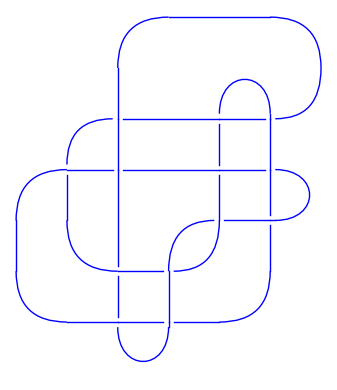

In [53]:
D=snappy.Link('K13n2527')

print(D.signature())
print(D.alexander_polynomial())
print(D.knot_floer_homology())

D.sage_link().plot()

0
t^6 - 2*t^5 + 3*t^4 - 5*t^3 + 3*t^2 - 2*t + 1
{'L_space_knot': False, 'epsilon': 0, 'fibered': True, 'modulus': 2, 'nu': 0, 'ranks': {(-3, -3): 1, (-2, -2): 2, (-1, -1): 3, (0, 0): 5, (1, 1): 3, (2, 2): 2, (3, 3): 1}, 'seifert_genus': 3, 'tau': 0, 'total_rank': 17}


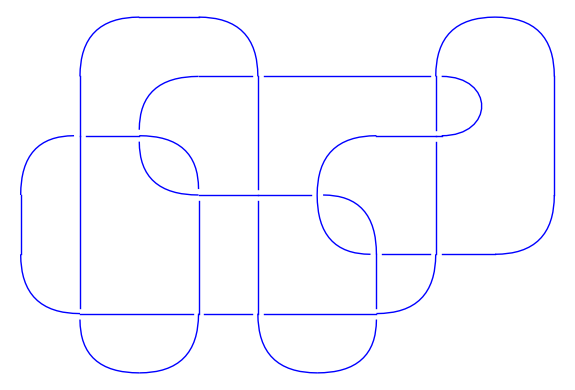

In [54]:
D=snappy.Link('K14n3155')

print(D.signature())
print(D.alexander_polynomial())
print(D.knot_floer_homology())

D.sage_link().plot()

-2
2*t^4 - t^3 - 3*t^2 - t + 2
{'L_space_knot': False, 'epsilon': 0, 'fibered': False, 'modulus': 2, 'nu': 0, 'ranks': {(-2, -3): 1, (-2, -1): 1, (-1, -2): 2, (-1, -1): 3, (-1, 0): 2, (0, -1): 2, (0, 0): 7, (0, 1): 2, (1, 0): 2, (1, 1): 3, (1, 2): 2, (2, 1): 1, (2, 3): 1}, 'seifert_genus': 2, 'tau': 0, 'total_rank': 29}


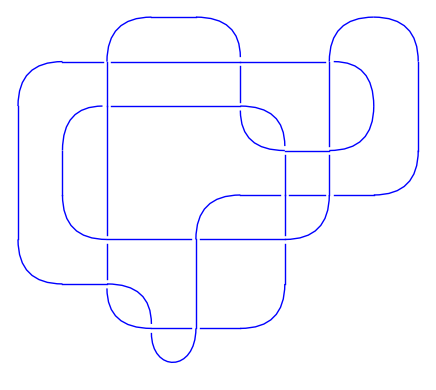

In [55]:
D=snappy.Link('K15n94464')

print(D.signature())
print(D.alexander_polynomial())
print(D.knot_floer_homology())

D.sage_link().plot()